# 04c_modality_usage_endoscopy.ipynb  
**Diagnostic Modality Analysis – Endoscopy Usage by Demographics and Procedure Type**

---

### **Aim**
This notebook explores patterns in **endoscopy procedures** by patient demographics (`age_band`, `gender`), sub-modality (e.g. **ERCP**, **gastroscopy**), and procedural labels.

It follows the same framework as `04a` (CT) and `04b` (MRI), and includes:
- Frequency tables of common endoscopy types  
- Crosstab analyses by `age_band × endoscopy_type`  
- Plots showing demand variation across key demographic groups  
- Referral type and patient source breakdowns  

---

### **Purpose**
To inform diagnostic planning by identifying high-volume endoscopy procedures and their demographic characteristics, supporting **elective demand modelling**.

---

### **Output**
- Top procedures by frequency  
- Visualisations of age × modality relationships  
- Tables and plots for use in LSOA-level modelling workflows  

---

### **Notes**
- **Cancer-specific fields are excluded** (focus is on general diagnostic usage)  
- Column naming conventions are aligned with the 04x series  
- This notebook will inform design of upcoming `04d` (CT) and `04e` (MRI) notebooks  

---


Imports & Raw-Folder Ingestion

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ----------- 1A. Point to your raw folder OR hard-code the list ----------
raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"
csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))

if not csv_files:
    raise FileNotFoundError("csv_files list is empty – check raw_dir or paths")

print(f"Detected {len(csv_files)} files")

# ----------- canonical 23-column schema from the SQL query ---------------
expected_cols = [
    'icb_code','icb_name','lsoa_code','nhs_region',
    'site_code','site_name','provider_code','provider_name',
    'activity_month','financial_year','financial_month','test_date',
    'age','sex','modality','sub_modality','procedure_name',
    'referral_type','patient_source','cancer_flag','subcancer_flag',
    'referring_org_code','referring_org_name'
]

dfs, meta = [], []
for fp in csv_files:
    peek = pd.read_csv(fp, nrows=5)
    if not set(expected_cols).issubset(peek.columns):
        print(f" {os.path.basename(fp)} – no header found, re-loading with names")
        df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
    else:
        df_tmp = pd.read_csv(fp, low_memory=False)

    df_tmp = df_tmp.dropna(axis=1, how='all')
    df_tmp.columns = df_tmp.columns.str.strip().str.lower()
    df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
    for col in (set(expected_cols) - set(df_tmp.columns)):
        df_tmp[col] = pd.NA
    df_tmp = df_tmp[expected_cols]
    dfs.append(df_tmp)

    meta.append({
        "file": os.path.basename(fp),
        "rows": len(df_tmp),
        "cols": df_tmp.shape[1],
        "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
    })

meta_df = pd.DataFrame(meta)
display(meta_df.style.set_caption("Loaded files – rows / cols / size"))

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}")  # expect ~4 M × 23

# Basic type coercion
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["test_date"] = pd.to_datetime(df["test_date"], errors="coerce")
df["activity_month"] = pd.to_datetime(
    df["activity_month"].astype(str), format="%Y%m", errors="coerce"
)


Detected 7 files
 2024_NHS_SW_Somerset_ICB_11X.csv – no header found, re-loading with names
 2024_NHS_SW_Cornwall_ICB_11N.csv – no header found, re-loading with names
 2024_NHS_SW_Gloucestershire_ICB_11M.csv – no header found, re-loading with names
 2024_NHS_SW_Dorset_ICB_11J.csv – no header found, re-loading with names
 2024_NHS_SW_Devon_ICB_15N.csv – no header found, re-loading with names
 2024_NHS_SW_BSW_ICB_92G.csv – no header found, re-loading with names
 2024_NHS_SW_BNSSG_ICB_15C.csv – no header found, re-loading with names


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000


Combined shape: (3989252, 23)


Clean & Bucket Patient Source

In [2]:
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .str.replace(r"\s+-\s+", " – ", regex=True)
      .replace({"nan": np.nan})
      .fillna("unknown")
)

bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":             "GP",
    r"inpatient":                 "Inpatient",
    r"outpatient":                "Outpatient",
    r"elective|planned":          "Elective",
}
def ps_bucket(txt: str) -> str:
    for pat, lab in bucket_map.items():
        if re.search(pat, txt):
            return lab
    return "Other/Unknown"

df["ps_bucket"] = df["patient_source"].apply(ps_bucket)
df["ps_bucket"].value_counts(dropna=False)


ps_bucket
Outpatient       1428095
GP                923522
Emergency         832850
Inpatient         695375
Other/Unknown     109410
Name: count, dtype: int64

ONS 5-Year Age Bands

In [4]:
# Define ONS-style bands
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
             "75-79","80-84","85+"]
})
bins   = bands["lower"].tolist() + [np.inf]
labels = bands["label"]

# Keep only whole-number ages
df = df[df["age"].notna() & (df["age"] % 1 == 0)]
df["age"] = df["age"].astype(int)
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=True)


Columns to Summarise

In [14]:
for col in ['modality', 'sub_modality', 'procedure_name']:
    print(f"\n Top 100 values for: {col}")

    vc = df[col].value_counts(dropna=False)
    total = vc.sum()

    top100 = vc.head(100).reset_index()
    top100.columns = [col, "Count"]
    top100["% of Total"] = (top100["Count"] / total * 100).round(2)

    display(
        top100.style
            .set_caption(f"Top 100: {col} (Count and %)")
            .format({"Count": "{:,}", "% of Total": "{:.2f}%"})
            .background_gradient(cmap="Blues", subset=["Count"])
    )

    print(f"Unique values in {col!r}: {df[col].nunique(dropna=False)}")


 Top 100 values for: modality


,modality,Count,% of Total
0,Plain radiography (procedure),"1,561,194",39.14%
1,Diagnostic ultrasonography (procedure),"782,294",19.61%
2,Computerized axial tomography (procedure),"647,463",16.23%
3,nan,"510,252",12.79%
4,Magnetic resonance imaging (procedure),"324,885",8.14%
5,Fluoroscopy (procedure),"92,541",2.32%
6,Nuclear medicine procedure (procedure),"29,358",0.74%
7,Positron emission tomography (procedure),"24,039",0.60%
8,Endoscopy (procedure),"7,174",0.18%
9,Single photon emission computerized tomography (procedure),"3,563",0.09%


Unique values in 'modality': 12

 Top 100 values for: sub_modality


,sub_modality,Count,% of Total
0,nan,"3,897,393",97.70%
1,X-ray photon absorptiometry (procedure),"42,811",1.07%
2,Diagnostic Doppler ultrasonography (procedure),"26,540",0.67%
3,Positron emission tomography with computed tomography (procedure),"20,614",0.52%
4,Single photon emission computed tomography with computed tomography (procedure),"1,830",0.05%


Unique values in 'sub_modality': 5

 Top 100 values for: procedure_name


,procedure_name,Count,% of Total
0,Plain chest X-ray (procedure),"386,207",9.68%
1,Plain chest X-ray (procedure) (399208008),"298,780",7.49%
2,Computed tomography of entire head (procedure),"92,626",2.32%
3,Computed tomography of entire head (procedure) (408754009),"69,122",1.73%
4,Ultrasonography of abdomen (procedure),"50,641",1.27%
5,Ultrasound scan for fetal growth (procedure),"45,361",1.14%
6,"Computed tomography of thorax, abdomen and pelvis with contrast (procedure)","45,150",1.13%
7,Transthoracic echocardiography (procedure) (433236007),"41,864",1.05%
8,"Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)","35,316",0.89%
9,Computed tomography of abdomen and pelvis with contrast (procedure),"34,668",0.87%


Unique values in 'procedure_name': 3759


Explore Endoscopy in dataframe

In [39]:
df_endoscopy = df[df['modality'] == 'Endoscopy (procedure)'].copy()
print(f"Endoscopy procedures: {len(df_endoscopy):,}")


Endoscopy procedures: 7,174


In [40]:
df_endoscopy["procedure_name"].value_counts(dropna=False).head(30)


procedure_name
Endoscopic retrograde cholangiopancreatography (procedure)                                                                                   1734
Endoscopic retrograde cholangiopancreatography (procedure) (386718000)                                                                       1596
Endoscopy of stomach (procedure)                                                                                                              951
Colonoscopy (procedure)                                                                                                                       860
Ureteroscopy (procedure)                                                                                                                      592
Ureteroscopy (procedure) (387717002)                                                                                                          544
Endoscopy of large intestine (procedure)                                                                     

In [41]:
def classify_endoscopy(proc: str) -> str:
    if pd.isna(proc):
        return "Unknown"
    proc = proc.lower()
    if "colonoscopy" in proc:
        return "Colonoscopy"
    elif "sigmoidoscopy" in proc:
        return "Sigmoidoscopy"
    elif "gastroscopy" in proc or "stomach" in proc:
        return "Gastroscopy"
    elif "ercp" in proc or "cholangiopancreatography" in proc:
        return "ERCP"
    elif "bronchoscopy" in proc:
        return "Bronchoscopy"
    elif "ureteroscopy" in proc:
        return "Ureteroscopy"
    elif "laparoscopy" in proc:
        return "Laparoscopy"
    elif "endoscopy" in proc:
        return "Generic Endoscopy"
    else:
        return "Other"

df_endoscopy["endoscopy_type"] = df_endoscopy["procedure_name"].apply(classify_endoscopy)


In [42]:
df_endoscopy["endoscopy_type"].value_counts()


endoscopy_type
ERCP                 3573
Ureteroscopy         1136
Gastroscopy           960
Colonoscopy           863
Generic Endoscopy     304
Bronchoscopy          248
Sigmoidoscopy          63
Other                  26
Laparoscopy             1
Name: count, dtype: int64

In [43]:
pd.crosstab(df_endoscopy["icb_name"], df_endoscopy["endoscopy_type"], margins=True)


endoscopy_type,Bronchoscopy,Colonoscopy,ERCP,Gastroscopy,Generic Endoscopy,Laparoscopy,Other,Sigmoidoscopy,Ureteroscopy,All
icb_name,,,,,,,,,,
"NHS BATH AND NORTH EAST SOMERSET, SWINDON AND WILTSHIRE ICB - 92G",2,761,526,763,259,0,4,52,1,2368
"NHS BRISTOL, NORTH SOMERSET AND SOUTH GLOUCESTERSHIRE ICB - 15C",6,0,795,7,3,0,0,0,0,811
NHS CORNWALL AND THE ISLES OF SCILLY ICB - 11N,69,2,547,4,1,0,17,0,232,872
NHS DEVON ICB - 15N,159,1,538,2,2,0,5,0,398,1105
NHS DORSET ICB - 11J,8,96,493,173,37,0,0,11,344,1162
NHS GLOUCESTERSHIRE ICB - 11M,1,2,184,0,2,0,0,0,161,350
NHS SOMERSET ICB - 11X,3,1,490,11,0,1,0,0,0,506
All,248,863,3573,960,304,1,26,63,1136,7174


In [44]:
pd.crosstab(df_endoscopy["age_band"], df_endoscopy["endoscopy_type"], margins=True)


endoscopy_type,Bronchoscopy,Colonoscopy,ERCP,Gastroscopy,Generic Endoscopy,Laparoscopy,Other,Sigmoidoscopy,Ureteroscopy,All
age_band,,,,,,,,,,
0-4,3,0,0,2,4,0,0,0,0,9
5-9,0,0,0,3,0,1,1,0,0,5
10-14,5,1,0,8,0,0,0,0,0,14
15-19,3,4,10,15,3,0,0,0,8,43
20-24,0,8,24,16,4,0,1,2,12,67
25-29,1,25,61,25,12,0,0,1,23,148
30-34,2,21,72,25,7,0,0,1,39,167
35-39,6,30,89,43,14,0,1,1,39,223
40-44,10,55,79,45,18,0,0,2,39,248


In [45]:
pd.crosstab(df_endoscopy["ps_bucket"], df_endoscopy["endoscopy_type"], margins=True)


endoscopy_type,Bronchoscopy,Colonoscopy,ERCP,Gastroscopy,Generic Endoscopy,Laparoscopy,Other,Sigmoidoscopy,Ureteroscopy,All
ps_bucket,,,,,,,,,,
Emergency,0,0,15,4,0,0,1,0,3,23
GP,0,0,3,0,0,0,0,0,0,3
Inpatient,25,36,2155,82,32,0,18,6,376,2730
Other/Unknown,9,824,655,874,271,1,6,57,655,3352
Outpatient,214,3,745,0,1,0,1,0,102,1066
All,248,863,3573,960,304,1,26,63,1136,7174


<Axes: title={'center': 'Monthly Endoscopy Volume'}, xlabel='month'>

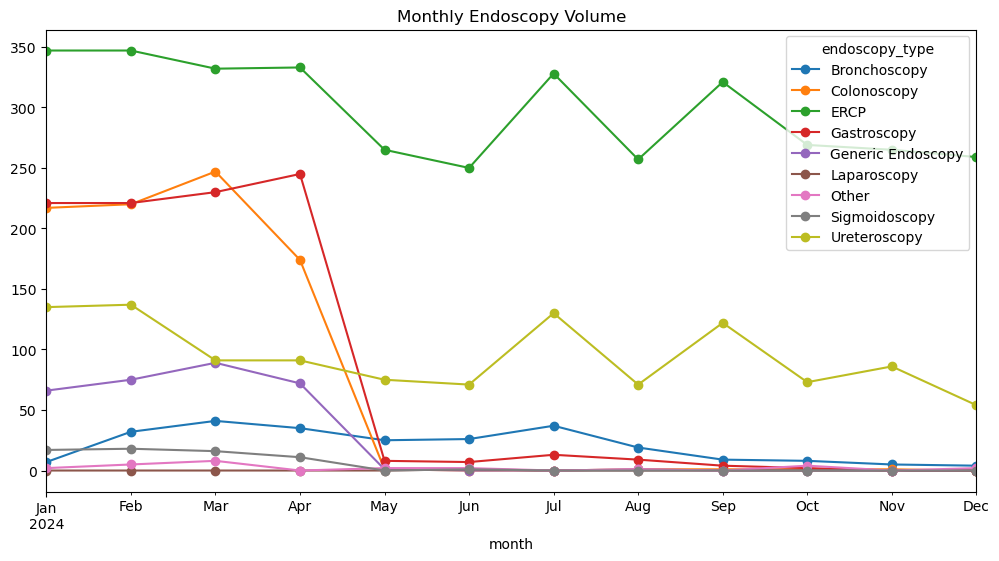

In [46]:
df_endoscopy["month"] = df_endoscopy["activity_month"].dt.to_period("M")

df_endoscopy.groupby(["month", "endoscopy_type"]) \
    .size().unstack(fill_value=0) \
    .plot(figsize=(12, 6), title="Monthly Endoscopy Volume", marker='o')


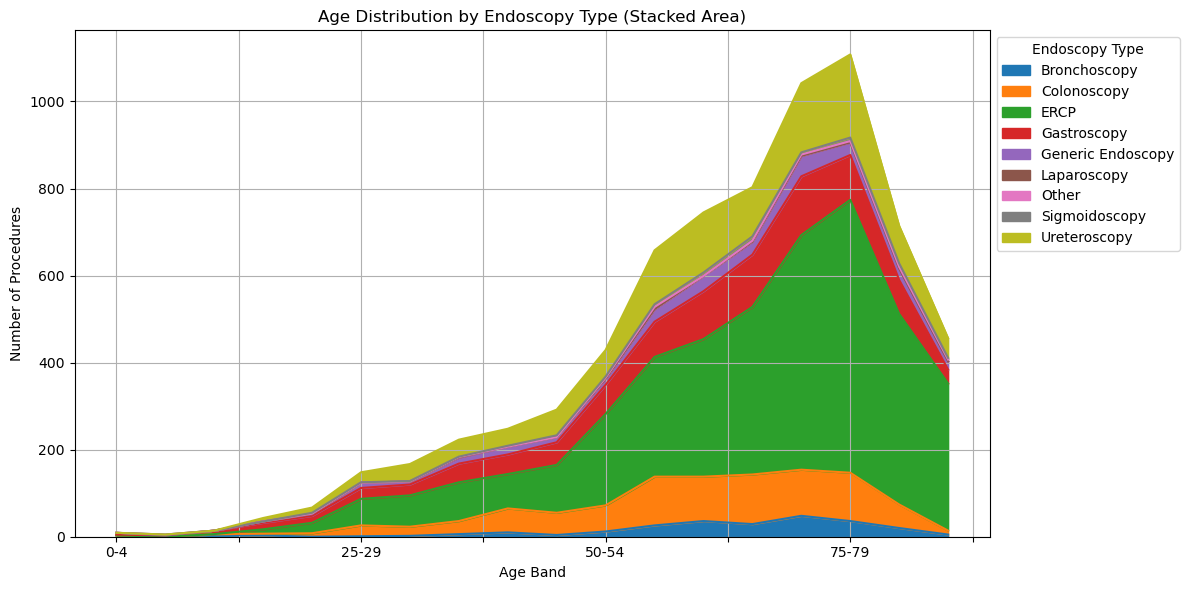

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure df_endoscopy exists with 'age_band' and 'endoscopy_type'

# Sort age bands in natural order
sorted_bands = sorted(
    df_endoscopy["age_band"].dropna().unique(),
    key=lambda x: int(str(x).split('-')[0].replace('+', ''))
)

# Create age_band × endoscopy_type crosstab
age_xtab = pd.crosstab(df_endoscopy["age_band"], df_endoscopy["endoscopy_type"])
age_xtab = age_xtab.reindex(index=sorted_bands)

# Plot: stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
age_xtab.plot(kind="area", stacked=True, ax=ax)

ax.set_title("Age Distribution by Endoscopy Type (Stacked Area)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Number of Procedures")
ax.legend(title="Endoscopy Type", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


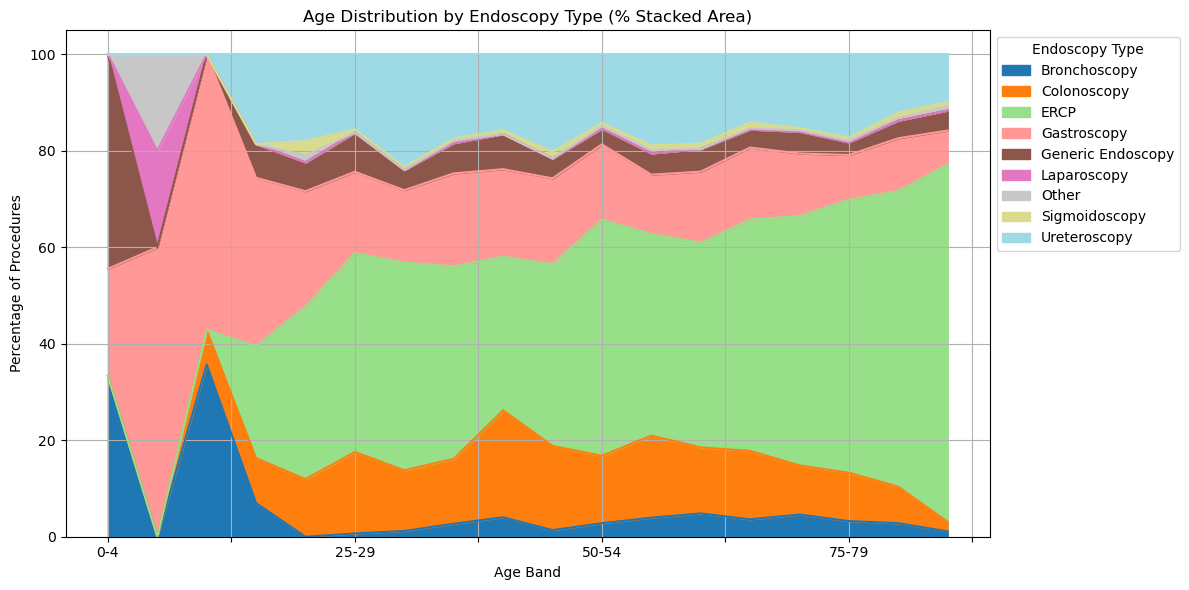

In [48]:
age_xtab_pct = age_xtab.div(age_xtab.sum(axis=1), axis=0) * 100
age_xtab_pct.plot(kind="area", stacked=True, figsize=(12, 6), cmap="tab20")

plt.title("Age Distribution by Endoscopy Type (% Stacked Area)")
plt.xlabel("Age Band")
plt.ylabel("Percentage of Procedures")
plt.legend(title="Endoscopy Type", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()
